In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utility import *

In [2]:
combo2stitch, combo2se, se2name = load_combo_se()
net, node2idx = load_ppi()
stitch2se, se2name_mono = load_mono_se()
stitch2proteins = load_targets()
se2class, se2name_class = load_categories()
se2name.update(se2name_mono)
se2name.update(se2name_class)

Reading: ../data/decagon_data/bio-decagon-combo.csv
Drug combinations: 63473 Side effects: 1317
Drug-drug interactions: 4649441
Reading: ../data/decagon_data/bio-decagon-ppi.csv
Edges: 715612
Nodes: 19081
Reading: ../data/decagon_data/bio-decagon-mono.csv
Reading: ../data/decagon_data/bio-decagon-targets-all.csv
Reading: ../data/decagon_data/bio-decagon-effectcategories.csv


In [27]:
# read in se scores
all_se_scores = pd.read_csv("../training/trained_models/model_scores/drivenn_training_all_dps.csv")[["se", "roc", "aupr"]]
cvd_se_scores = pd.read_csv("../training/trained_models/model_scores/cvd_drivenn_training_cvd_dps.csv")[["se", "roc", "aupr"]]

# read in severity scores
severity_df = pd.read_csv("../data/ADR_severity_data/SAEDR_scores.csv")

In [28]:
# create df of side effect names and categories

se_classes = pd.DataFrame({"se_code": list(se2class.keys()),
             "se_class": list(se2class.values())})

se_names = pd.DataFrame({"se_code": list(se2name.keys()),
                        "se_name": list(se2name.values())})

se_df_all = pd.merge(se_classes, se_names, on = "se_code", how = "right")

In [43]:
# merge severity df with side effect names and roc/aupr

drivenn_all = pd.merge(pd.merge(all_se_scores, se_df_all, how="left", left_on="se", right_on="se_code"), severity_df, how="left", left_on="se", right_on="cui")
drivenn_cvd = pd.merge(pd.merge(cvd_se_scores, se_df_all, how="left", left_on="se", right_on="se_code"), severity_df, how="left", left_on="se", right_on="cui")

# select side effects that have a severity score that is not null
drivenn_all = drivenn_all[~drivenn_all['saedr_score'].isna()]
drivenn_cvd = drivenn_cvd[~drivenn_cvd['saedr_score'].isna()]


# Look at Severity Bins

In [33]:
# bins for saeder scores

def f(score):
    sev_dict = {"low": (0,0.2), "minor": (0.2, 0.4), "moderate": (0.4, 0.6), "major": (0.6, 0.8), "critical": (0.8, 1)}
    
    if score < 0.2:
        return "low"
    elif score < 0.4:
        return "minor"
    elif score < 0.6:
        return "moderate"
    elif score < 0.8:
        return "major"
    else:
        return "critical"

In [60]:
# bins for roc/aupr scores

def g(score):
    if score > 0.95:
        return "> 0.95"
    elif score > 0.9:
        return "(0.9, 0.95)"
    elif score > 0.85:
        return "(0.85, 0.90)"
    elif score > 0.8:
        return "(0.8, 0.85)"
    else:
        return "(0, 0.8)"

In [61]:
# bins for easier analysis
drivenn_all['severity_bin'] = drivenn_all.saedr_score.apply(f)
drivenn_all['roc_bin'] = drivenn_all.roc.apply(g)
drivenn_all['aupr_bin'] = drivenn_all.aupr.apply(g)

drivenn_cvd['severity_bin'] = drivenn_cvd.saedr_score.apply(f)
drivenn_cvd['roc_bin'] = drivenn_cvd.roc.apply(g)
drivenn_cvd['aupr_bin'] = drivenn_cvd.aupr.apply(g)

In [62]:
drivenn_cvd.groupby(["roc_bin"]).agg({"se_name": list, "se": len,  "saedr_score": 'median'})

,se_name,se,saedr_score
roc_bin,,,
"(0, 0.8)","[nervous tension, Pain, alopecia, eruption, in...",213,0.593920
"(0.8, 0.85)","[malnourished, azotaemia, arteriosclerotic hea...",27,0.607647
"(0.85, 0.90)","[heart attack, blood sodium decreased, Difficu...",9,0.664826
"(0.9, 0.95)","[cardiac enlargement, epistaxis, Hypotension O...",13,0.553373
> 0.95,"[Feeling unwell, facial flushing, dysarthria, ...",18,0.593467


In [63]:
drivenn_cvd.groupby(["aupr_bin"]).agg({"se_name": list, "se": len,  "saedr_score": 'median'})

,se_name,se,saedr_score
aupr_bin,,,
"(0, 0.8)","[nervous tension, Pain, alopecia, eruption, in...",245,0.604713
"(0.8, 0.85)",[adenocarcinoma],1,0.806116
"(0.85, 0.90)","[epistaxis, joint swelling, fungal disease, ca...",4,0.534778
"(0.9, 0.95)","[cardiac enlargement, disorder Renal, bone mar...",10,0.596760
> 0.95,"[Feeling unwell, facial flushing, dysarthria, ...",20,0.593467


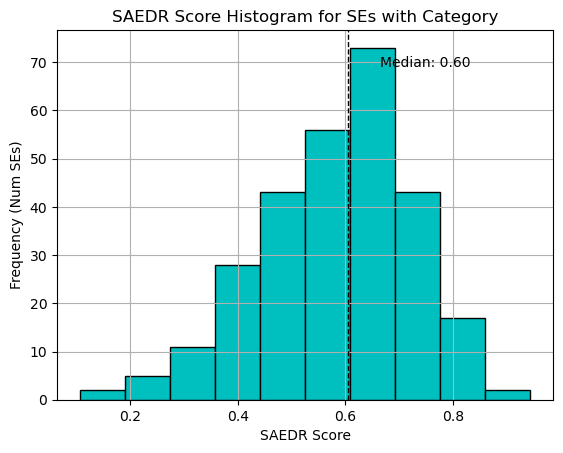

In [65]:

drivenn_cvd.saedr_score.hist(color='c', edgecolor='k')

# add median line
median = drivenn_cvd.saedr_score.median()
plt.axvline(median, color='k', linestyle='dashed', linewidth=1)

# add graph labels
plt.xlabel('SAEDR Score')
plt.ylabel('Frequency (Num SEs)')
min_ylim, max_ylim = plt.ylim()
plt.text(median*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(median))
plt.title("SAEDR Score Histogram for SEs with Category");